In [8]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

import numpy as np

# Create a Spark session
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()
sc = SparkContext.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")



In [9]:

def readFile(filename):

    # Read the file into an RDD
    lines = sc.textFile(filename)

    # Process each line in the RDD, each element in data ends in a tuple containing a list of the first 11 features, and a number representing the target
    data = lines.map(lambda line: line.split(','))\
                .map(lambda elem: ([float(x) for x in elem[:-1]], int(elem[-1])))

    return data

In [10]:
# Function that computes the means and std devs
def compute_mean_stds(RDD):

    # Calculate sum and sum of squares for each feature
    sums = RDD.map(lambda x: x[0]).reduce(lambda a, b: a+b)
    sum_of_squares = RDD.map(lambda x: x[0]**2).reduce(lambda a, b: a+b)
    count = RDD.count()

    # Compute mean and standard deviation for each feature
    means = sums / count
    stds = ((sum_of_squares / count) - means ** 2) ** 0.5 
    
    return means, stds


def normalize(RDD_Xy):
    # Compute means and standard deviations
    means, stds = compute_mean_stds(RDD_Xy)

    normalized_RDD = RDD_Xy.map(lambda x: ((x[0] - means) / stds , x[1]))
    return normalized_RDD



In [11]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Function that computes the value z, which is indeed a linear combination of weights and features + the bias
def linear_combination(features, weights, bias):
    return sum(weights[j] * features[j] for j in range(len(weights))) + bias


# Function to compute the gradient of each record (row) of the dataset
def compute_gradients_and_cost(record, weights, bias):
    xi, yi = record

    y_hat = sigmoid(linear_combination(xi, weights, bias))
    error = y_hat - yi
    dw = np.zeros(len(weights))

    for j in range(len(weights)):
        dw[j] = error * xi[j]
    
    db = error
    cost_contribution = -yi * np.log(y_hat) - (1 - yi) * np.log(1 - y_hat)
    
    return (dw, db, cost_contribution)


# Actual train function
def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    np.random.seed(0) 
    feature_count = len(RDD_Xy.first()[0])
    w = np.random.rand(feature_count)
    b = np.random.rand()
    m = RDD_Xy.count()

    for n in range(iterations):
        
        gradients_and_cost = RDD_Xy.map(lambda x: compute_gradients_and_cost(x, w, b))
        dw, db, total_cost = gradients_and_cost.reduce(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2]))
        
        reg_cost = (lambda_reg / (2 * feature_count)) * np.sum(np.square(w))
        cost = (total_cost / m) + reg_cost
        
        # Update weights and bias
        w -= learning_rate * ((dw / m) + (lambda_reg/m) * w)
        b -= learning_rate * db / m


        print(f"Iteration {n+1}/{iterations} - Cost: {cost}")

    return w, b


In [12]:
# Predict function
def predict(w, b, x):
    z = 0
    for j in range(len(w)):
        z += w[j] * x[j]

    z+= b
    # Compute the sigmoid of z
    y_hat = sigmoid(z)

    if y_hat > 0.5:
        return 1
    else: 
        return 0




In [13]:
# Accuracy function
def accuracy(w, b, RDD_Xy):
    
    results = RDD_Xy.map(lambda r: 1 if predict(w, b, r[0]) == r[1] else 0)
    results = results.reduce( lambda a, b: a + b)

    accuracy = results / RDD_Xy.count()
    return accuracy




In [14]:
import numpy as np

def get_uniform_number(min=1, max=10):
    # Generate a float number from uniform distribution
    float_number = np.random.uniform(min, max + 0.9999)

    # Round the float number to the nearest integer, ensuring it's between 1 and 10, inclusive
    int_number = int(np.clip(float_number, 1, 10))

    return int_number


def assign_uniform_blocks(RDD):

    def assign_block(record):
        block_num = get_uniform_number(0, 10)
        return record + (block_num,)

    RDD_with_blocks = RDD.map(assign_block)

    return RDD_with_blocks


In [15]:
def cross_validate(RDD_Xy_with_blocks, num_blocks=10, iterations=10, learning_rate=1.5, lambda_reg=0):
    total_accuracy = 0

    for test_block in range(1, num_blocks + 1):
        
        training_RDD = RDD_Xy_with_blocks.flatMap(lambda x: [(x[0], x[1])] if x[-1] != test_block else [])
        test_RDD = RDD_Xy_with_blocks.flatMap(lambda x: [(x[0], x[1])] if x[-1] == test_block else [])

        w, b = train(training_RDD, iterations, learning_rate, lambda_reg)

        current_accuracy = accuracy(w, b, test_RDD)
        print(f"Accuracy for block {test_block} as test set: {current_accuracy}")

        total_accuracy += current_accuracy

    average_accuracy = total_accuracy / num_blocks
    return average_accuracy



In [16]:
import os
import sys
import time
import pyspark
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
sc.stop()
times = []
for i in [10, 12]:
    print("Number of cores: ", i)
    start_time = time.time()
    number_cores = i
    conf = (
        pyspark.SparkConf()
            .setMaster('local[{}]'.format(number_cores))
    )
    sc = pyspark.SparkContext(conf=conf)

    filename = 'data/botnet_tot_syn_l.csv'
    RDD_Xy = readFile(filename).map( lambda x: (np.array(x[0]), x[1]))
    normalized_RDD = normalize(RDD_Xy)
    RDD_Xy_with_blocks = assign_uniform_blocks(normalized_RDD)
    average_accuracy = cross_validate(RDD_Xy_with_blocks)
    print("Average Cross-Validation Accuracy:", average_accuracy)
    times.append(time.time() - start_time)
    sc.stop()

Number of cores:  10


Iteration 1/10 - Cost: 1.5017806084846044


Iteration 2/10 - Cost: 0.7445272363100951


Iteration 3/10 - Cost: 0.44724293163187656


Iteration 4/10 - Cost: 0.33701139423251475


Iteration 5/10 - Cost: 0.2860218773463568


Iteration 6/10 - Cost: 0.2580418871161585


Iteration 7/10 - Cost: 0.24044140069841488


Iteration 8/10 - Cost: 0.22840684489154764


Iteration 9/10 - Cost: 0.22013776272604738


Iteration 10/10 - Cost: 0.21300551195033093


Accuracy for block 1 as test set: 0.9182200743005556


Iteration 1/10 - Cost: 1.499918741530918


Iteration 2/10 - Cost: 0.7445808709287904


Iteration 3/10 - Cost: 0.44615338540857813


Iteration 4/10 - Cost: 0.33615267266475046


Iteration 5/10 - Cost: 0.2855547588184106


Iteration 6/10 - Cost: 0.2579845056483903


Iteration 7/10 - Cost: 0.24050734759093087


Iteration 8/10 - Cost: 0.22853504397418384


Iteration 9/10 - Cost: 0.21996074444985836


Iteration 10/10 - Cost: 0.21327519812896442


Accuracy for block 2 as test set: 0.9253054680157019


Iteration 1/10 - Cost: 1.4989805050236373


Iteration 2/10 - Cost: 0.7451342664051664


Iteration 3/10 - Cost: 0.4463241939834533


Iteration 4/10 - Cost: 0.33545584359875213


Iteration 5/10 - Cost: 0.2860534145787436


Iteration 6/10 - Cost: 0.2579823651298343


Iteration 7/10 - Cost: 0.24075697791105477


Iteration 8/10 - Cost: 0.22861376263025396


Iteration 9/10 - Cost: 0.21973215375278077


Iteration 10/10 - Cost: 0.2132831276030084


Accuracy for block 3 as test set: 0.9299437391964944


Iteration 1/10 - Cost: 1.4973228726622059


Iteration 2/10 - Cost: 0.746059739132763


Iteration 3/10 - Cost: 0.44628729092454283


Iteration 4/10 - Cost: 0.3359620064587537


Iteration 5/10 - Cost: 0.28584295976058394


Iteration 6/10 - Cost: 0.25815411657981996


Iteration 7/10 - Cost: 0.24080510718716222


Iteration 8/10 - Cost: 0.2289113837807504


Iteration 9/10 - Cost: 0.21979852202203282


Iteration 10/10 - Cost: 0.2133141742098388


Accuracy for block 4 as test set: 0.926165533698948


Iteration 1/10 - Cost: 1.5002473826002878


Iteration 2/10 - Cost: 0.7456514775440752


Iteration 3/10 - Cost: 0.4464503333143131


Iteration 4/10 - Cost: 0.3358941174805527


Iteration 5/10 - Cost: 0.28545507797715663


Iteration 6/10 - Cost: 0.25829405536116123


Iteration 7/10 - Cost: 0.24087238449172732


Iteration 8/10 - Cost: 0.22890347861078142


Iteration 9/10 - Cost: 0.2201750293784773


Iteration 10/10 - Cost: 0.21320657411143712


Accuracy for block 5 as test set: 0.9329533804416126


Iteration 1/10 - Cost: 1.5001681221999041


Iteration 2/10 - Cost: 0.745580462308654


Iteration 3/10 - Cost: 0.44631606744162533


Iteration 4/10 - Cost: 0.3362546144262896


Iteration 5/10 - Cost: 0.2855967028318082


Iteration 6/10 - Cost: 0.2582346793253612


Iteration 7/10 - Cost: 0.2405748946686459


Iteration 8/10 - Cost: 0.22885424286513964


Iteration 9/10 - Cost: 0.22010635072669998


Iteration 10/10 - Cost: 0.21338430739540837


Accuracy for block 6 as test set: 0.9366359828937045


Iteration 1/10 - Cost: 1.4989944016531276


Iteration 2/10 - Cost: 0.7456126425767193


Iteration 3/10 - Cost: 0.44621629822161507


Iteration 4/10 - Cost: 0.3359212982204655


Iteration 5/10 - Cost: 0.28570630800275215


Iteration 6/10 - Cost: 0.25815090191965345


Iteration 7/10 - Cost: 0.24074026666865891


Iteration 8/10 - Cost: 0.22880956056162918


Iteration 9/10 - Cost: 0.22023550444080417


Iteration 10/10 - Cost: 0.21333801074761055


Accuracy for block 7 as test set: 0.926578819796395


Iteration 1/10 - Cost: 1.4997936947154291


Iteration 2/10 - Cost: 0.7453799296366997


Iteration 3/10 - Cost: 0.44598183052562634


Iteration 4/10 - Cost: 0.3359213829867983


Iteration 5/10 - Cost: 0.28581723706639345


Iteration 6/10 - Cost: 0.25818569586252715


Iteration 7/10 - Cost: 0.24077771014185528


Iteration 8/10 - Cost: 0.22880027606372652


Iteration 9/10 - Cost: 0.220075108819018


Iteration 10/10 - Cost: 0.21309979653459357


Accuracy for block 8 as test set: 0.9272689301926819


Iteration 1/10 - Cost: 1.5002701322863121


Iteration 2/10 - Cost: 0.7449644204621723


Iteration 3/10 - Cost: 0.44676727679219363


Iteration 4/10 - Cost: 0.33610029615510423


Iteration 5/10 - Cost: 0.28579540625148475


Iteration 6/10 - Cost: 0.25810910917471414


Iteration 7/10 - Cost: 0.24072860910653826


Iteration 8/10 - Cost: 0.22877728692860447


Iteration 9/10 - Cost: 0.21997114673343982


Iteration 10/10 - Cost: 0.21317643157176766


Accuracy for block 9 as test set: 0.9308435244091373


Iteration 1/10 - Cost: 1.5005447863585568


Iteration 2/10 - Cost: 0.7451281570436337


Iteration 3/10 - Cost: 0.44620853187114023


Iteration 4/10 - Cost: 0.33565374853556074


Iteration 5/10 - Cost: 0.28592375633451383


Iteration 6/10 - Cost: 0.2582076965177024


Iteration 7/10 - Cost: 0.24076570945120596


Iteration 8/10 - Cost: 0.22874461129233387


Iteration 9/10 - Cost: 0.22001821343219413


Iteration 10/10 - Cost: 0.2131367597195783


Accuracy for block 10 as test set: 0.9306273547708753
Average Cross-Validation Accuracy: 0.9284542807716107
Number of cores:  12


Iteration 1/10 - Cost: 1.5005202772389346


Iteration 2/10 - Cost: 0.7445257335907235


Iteration 3/10 - Cost: 0.4472753430191895


Iteration 4/10 - Cost: 0.33578619403900406


Iteration 5/10 - Cost: 0.2861593664543568


Iteration 6/10 - Cost: 0.25814258890855235


Iteration 7/10 - Cost: 0.24051388628370352


Iteration 8/10 - Cost: 0.2286661464018794


Iteration 9/10 - Cost: 0.2202047471028653


Iteration 10/10 - Cost: 0.21359163114160343


Accuracy for block 1 as test set: 0.9202036418015482


Iteration 1/10 - Cost: 1.5002100361505293


Iteration 2/10 - Cost: 0.7452292565292407


Iteration 3/10 - Cost: 0.44592900682307685


Iteration 4/10 - Cost: 0.3359709346519166


Iteration 5/10 - Cost: 0.2857326905988722


Iteration 6/10 - Cost: 0.25844663964942444


Iteration 7/10 - Cost: 0.2408765206641882


Iteration 8/10 - Cost: 0.22878474377959204


Iteration 9/10 - Cost: 0.21999420265879052


Iteration 10/10 - Cost: 0.21302997787529593


Accuracy for block 2 as test set: 0.9394390257342812


Iteration 1/10 - Cost: 1.498147396882748


Iteration 2/10 - Cost: 0.7456517727504629


Iteration 3/10 - Cost: 0.44630526954635946


Iteration 4/10 - Cost: 0.3359668726317038


Iteration 5/10 - Cost: 0.2857017413917036


Iteration 6/10 - Cost: 0.25805344313982886


Iteration 7/10 - Cost: 0.2408532190977019


Iteration 8/10 - Cost: 0.2287309253512042


Iteration 9/10 - Cost: 0.21983940048408762


Iteration 10/10 - Cost: 0.21318477913977787


Accuracy for block 3 as test set: 0.9296684731333786


Iteration 1/10 - Cost: 1.4995056279750416


Iteration 2/10 - Cost: 0.7460196538773622


Iteration 3/10 - Cost: 0.4467277435052482


Iteration 4/10 - Cost: 0.33597265808224136


Iteration 5/10 - Cost: 0.28589902165875586


Iteration 6/10 - Cost: 0.25849497485016776


Iteration 7/10 - Cost: 0.24108847432876412


Iteration 8/10 - Cost: 0.22896947310076418


Iteration 9/10 - Cost: 0.22011137275123574


Iteration 10/10 - Cost: 0.2130571433612409


Accuracy for block 4 as test set: 0.9257897797724205


Iteration 1/10 - Cost: 1.4982954276194858


Iteration 2/10 - Cost: 0.7450925886267097


Iteration 3/10 - Cost: 0.4466063975151556


Iteration 4/10 - Cost: 0.33583108132065964


Iteration 5/10 - Cost: 0.2857048158767631


Iteration 6/10 - Cost: 0.2583336598033369


Iteration 7/10 - Cost: 0.24082529788227866


Iteration 8/10 - Cost: 0.22879294923862417


Iteration 9/10 - Cost: 0.2198930493691057


Iteration 10/10 - Cost: 0.2131289198750923


Accuracy for block 5 as test set: 0.9262330955402862


Iteration 1/10 - Cost: 1.5004864965229998


Iteration 2/10 - Cost: 0.7453218875737


Iteration 3/10 - Cost: 0.44565938014168327


Iteration 4/10 - Cost: 0.33604717101373693


Iteration 5/10 - Cost: 0.2857709382288884


Iteration 6/10 - Cost: 0.25834109700482155


Iteration 7/10 - Cost: 0.24074660276580429


Iteration 8/10 - Cost: 0.22866863627519213


Iteration 9/10 - Cost: 0.22013388944651333


Iteration 10/10 - Cost: 0.21326023605701538


Accuracy for block 6 as test set: 0.9348640790651912


Iteration 1/10 - Cost: 1.500898598694589


Iteration 2/10 - Cost: 0.7454419232086898


Iteration 3/10 - Cost: 0.4461511094047151


Iteration 4/10 - Cost: 0.33580214755689985


Iteration 5/10 - Cost: 0.2857907392453261


Iteration 6/10 - Cost: 0.25844942994071096


Iteration 7/10 - Cost: 0.24068602689211716


Iteration 8/10 - Cost: 0.22865272455483537


Iteration 9/10 - Cost: 0.21990793701688113


Iteration 10/10 - Cost: 0.2133374269159218


Accuracy for block 7 as test set: 0.9353170613128846


Iteration 1/10 - Cost: 1.4990435801169641


Iteration 2/10 - Cost: 0.7452032231650221


Iteration 3/10 - Cost: 0.4466515293065066


Iteration 4/10 - Cost: 0.336041979725421


Iteration 5/10 - Cost: 0.285731363584282


Iteration 6/10 - Cost: 0.25801638445026703


Iteration 7/10 - Cost: 0.24077659822352532


Iteration 8/10 - Cost: 0.22881874423473905


Iteration 9/10 - Cost: 0.21978457452721345


Iteration 10/10 - Cost: 0.21331895534097153


Accuracy for block 8 as test set: 0.9312471775215059


Iteration 1/10 - Cost: 1.4985477100612161


Iteration 2/10 - Cost: 0.745665443909767


Iteration 3/10 - Cost: 0.44647655179146556


Iteration 4/10 - Cost: 0.3358454930430834


Iteration 5/10 - Cost: 0.2859666186008719


Iteration 6/10 - Cost: 0.2583935278923737


Iteration 7/10 - Cost: 0.24087639760850352


Iteration 8/10 - Cost: 0.22843339571597618


Iteration 9/10 - Cost: 0.21984587760723953


Iteration 10/10 - Cost: 0.21313619289170757


Accuracy for block 9 as test set: 0.9299652793038281


Iteration 1/10 - Cost: 1.4982406205732814


Iteration 2/10 - Cost: 0.7461319170175462


Iteration 3/10 - Cost: 0.4467257394366304


Iteration 4/10 - Cost: 0.3361097636706038


Iteration 5/10 - Cost: 0.285723082943815


Iteration 6/10 - Cost: 0.2582771500592313


Iteration 7/10 - Cost: 0.24062732096599654


Iteration 8/10 - Cost: 0.2287946242928349


Iteration 9/10 - Cost: 0.22015522987098127


Iteration 10/10 - Cost: 0.2133804559143641


Accuracy for block 10 as test set: 0.9308921613947039
Average Cross-Validation Accuracy: 0.9303619774580028


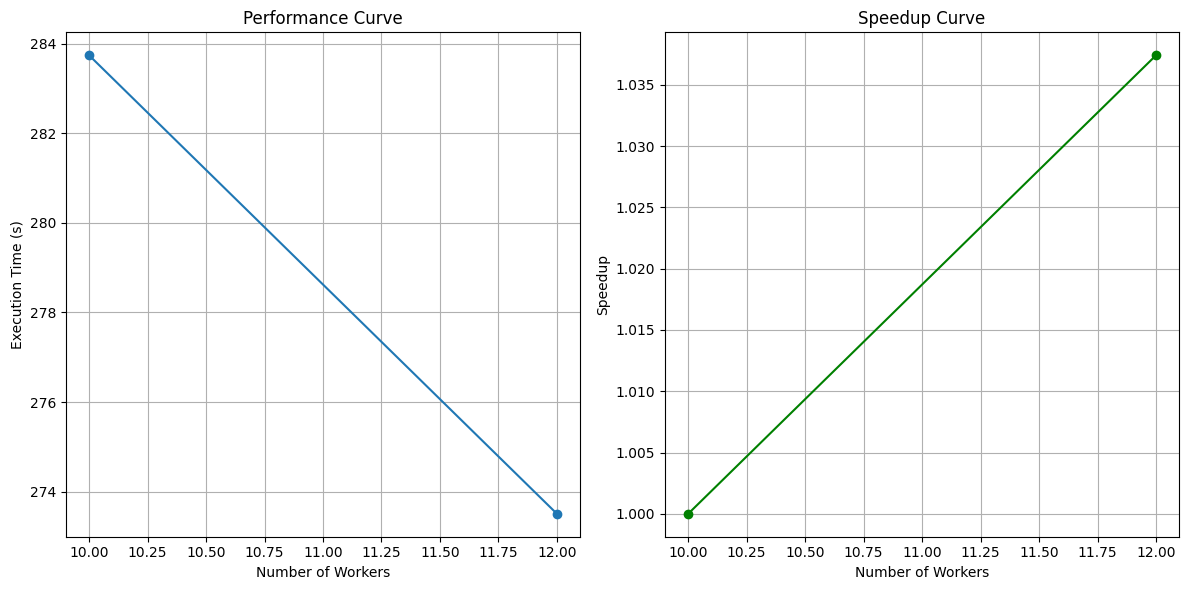

In [20]:
import matplotlib.pyplot as plt

# Replace this with your actual execution times

number_of_workers = list([10,12])  # Number of workers from 1 to 9

# Calculating speedup
base_time = times[0]  # Time taken for execution with 1 worker
speedup = [base_time / t for t in times]

# Plotting performance curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(number_of_workers, times, marker='o')
plt.title('Performance Curve')
plt.xlabel('Number of Workers')
plt.ylabel('Execution Time (s)')
plt.grid(True)

# Plotting speedup curve
plt.subplot(1, 2, 2)
plt.plot(number_of_workers, speedup, marker='o', color='green')
plt.title('Speedup Curve')
plt.xlabel('Number of Workers')
plt.ylabel('Speedup')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()